# 1. Setup and Initialization

Import all libraries required for preprocessing, modeling, tuning, and evaluation.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib  # For saving models and scalers
import os
# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import detrend
# ML Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# DL Models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Tuning and Interpretation
import optuna
import shap
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
# Setup plotting
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


# 2. Data Loading and Preprocessing

Load the aggregated data from the EDA notebook and apply the full preprocessing pipeline.

In [13]:
try:
    df = pd.read_csv("cleaned_crop_data.csv")
    print(f"Aggregated dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("ERROR: 'prediction_yield_aggregated.csv' not found. Please run the EDA notebook first.")
    # In a real scenario, you might stop execution here.
# Define feature columns
TARGET_COL = 'hg/ha_yield'
NUMERIC_COLS = [
    'average_rain_fall_mm_per_year',
    'pesticides_tonnes',
    'avg_temp',
    'fertilizer_kg/ha',
    'solar_radiation_MJ/m2-day'
]
CAT_COLS = ['Area', 'Item']
TIME_COL = 'Year'

Aggregated dataset loaded. Shape: (25932, 9)


**2.1. Group-wise Temporal De-trending**

We apply linear de-trending to the yield for each Area-Item group.

In [14]:
print("Applying group-wise temporal de-trending...")
df = df.sort_values(by=CAT_COLS + [TIME_COL])
df['yield_detrended'] = df.groupby(CAT_COLS)[TARGET_COL].transform(lambda x: detrend(x))
df['yield_trend'] = df[TARGET_COL] - df['yield_detrended']
TARGET_COL_DETRENDED = 'yield_detrended'

Applying group-wise temporal de-trending...


**2.2. Feature Engineering: Lagged Features (for RF/XGB)**

Create 1- and 2-year lags for temporal context in classical models.

In [15]:
print("Engineering lagged features for classical models...")
LAG_COLS = [TARGET_COL_DETRENDED] + NUMERIC_COLS
for col in LAG_COLS:
    for lag in [1, 2]:
        df[f'{col}_lag{lag}'] = df.groupby(CAT_COLS)[col].shift(lag)
# Drop rows with NA values created by lagging (the first 2 years of each group)
df_ml = df.dropna().copy()
print(f"Shape after lagging and dropping NAs: {df_ml.shape}")

Engineering lagged features for classical models...
Shape after lagging and dropping NAs: (24737, 23)


**2.3. Chronological Split (All Models)**

In [16]:
print("Performing chronological train-validation-test split...")
# Define split years
TRAIN_END_YEAR = 2007
VAL_END_YEAR = 2010
# Create dataframes for each set
train_df = df_ml[df_ml[TIME_COL] <= TRAIN_END_YEAR].copy()
val_df = df_ml[(df_ml[TIME_COL] > TRAIN_END_YEAR) & (df_ml[TIME_COL] <= VAL_END_YEAR)].copy()
test_df = df_ml[df_ml[TIME_COL] > VAL_END_YEAR].copy()
print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Performing chronological train-validation-test split...
Train set shape: (17857, 23)
Validation set shape: (3421, 23)
Test set shape: (3459, 23)


**2.4. Categorical Encoding**

We encode 'Area' and 'Item' for all models.

In [17]:
le_area = LabelEncoder()
le_item = LabelEncoder()
# Fit on the full dataset (all possible values)
df_ml['Area_Encoded'] = le_area.fit_transform(df_ml['Area'])
df_ml['Item_Encoded'] = le_item.fit_transform(df_ml['Item'])
# Map to the split dataframes
train_df['Area_Encoded'] = le_area.transform(train_df['Area'])
train_df['Item_Encoded'] = le_item.transform(train_df['Item'])
val_df['Area_Encoded'] = le_area.transform(val_df['Area'])
val_df['Item_Encoded'] = le_item.transform(val_df['Item'])
test_df['Area_Encoded'] = le_area.transform(test_df['Area'])
test_df['Item_Encoded'] = le_item.transform(test_df['Item'])
# Store vocabulary size for Embedding layers
N_AREAS = df_ml['Area_Encoded'].nunique()
N_ITEMS = df_ml['Item_Encoded'].nunique()
print(f"Total unique areas: {N_AREAS}, Total unique items: {N_ITEMS}")

Total unique areas: 101, Total unique items: 10


**2.5. Feature Scaling (Critical: Fit on Train Only)**

We scale all numeric features *and* the lagged features.

In [18]:
# Define all columns that need scaling
lagged_cols = [col for col in df_ml.columns if '_lag' in col]
COLS_TO_SCALE = NUMERIC_COLS + lagged_cols
scaler = StandardScaler()
# Fit ONLY on the training data
train_df[COLS_TO_SCALE] = scaler.fit_transform(train_df[COLS_TO_SCALE])
# Transform validation and test data
val_df[COLS_TO_SCALE] = scaler.transform(val_df[COLS_TO_SCALE])
test_df[COLS_TO_SCALE] = scaler.transform(test_df[COLS_TO_SCALE])
print("Scaling complete. Scaler fitted on training data only.")
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le_area, 'le_area.joblib')
joblib.dump(le_item, 'le_item.joblib')

Scaling complete. Scaler fitted on training data only.


['le_item.joblib']

# 3. Data Preparation for Model Input

We create the final X/y arrays for each model type.

**3.1. Tabular Data (for RF and XGBoost)**

In [19]:
ML_FEATURES = NUMERIC_COLS + lagged_cols + ['Area_Encoded', 'Item_Encoded']
X_train_ml = train_df[ML_FEATURES]
y_train_ml = train_df[TARGET_COL_DETRENDED]
X_val_ml = val_df[ML_FEATURES]
y_val_ml = val_df[TARGET_COL_DETRENDED]
X_test_ml = test_df[ML_FEATURES]
y_test_ml = test_df[TARGET_COL_DETRENDED]
print(f"X_train_ml shape: {X_train_ml.shape}")
print(f"X_test_ml shape: {X_test_ml.shape}")

X_train_ml shape: (17857, 19)
X_test_ml shape: (3459, 19)


**3.2. Sequential Data (for CNN and LSTM)**

We create 3D sequences with a 5-year lookback.

In [20]:
LOOKBACK = 5
DL_FEATURES = NUMERIC_COLS + ['Area_Encoded', 'Item_Encoded']  # No lags for DL models
def create_sequences(data, lookback, feature_cols, target_col):
    X, y = [], []
    groups = data.groupby(CAT_COLS)
    for _, group in groups:
        group_features = group[feature_cols].values
        group_target = group[target_col].values
        for i in range(len(group) - lookback + 1):
            X.append(group_features[i:i+lookback])
            y.append(group_target[i+lookback-1])  # Predict the last day in the window
    return np.array(X), np.array(y)
# We need the *un-lagged* data for sequencing. Re-split the original scaled data.
scaled_cols = NUMERIC_COLS + ['Area_Encoded', 'Item_Encoded']
scaler_dl = StandardScaler()
train_df_dl = df[df[TIME_COL] <= TRAIN_END_YEAR].copy()
val_df_dl = df[(df[TIME_COL] > TRAIN_END_YEAR) & (df[TIME_COL] <= VAL_END_YEAR)].copy()
test_df_dl = df[df[TIME_COL] > VAL_END_YEAR].copy()
train_df_dl['Area_Encoded'] = le_area.transform(train_df_dl['Area'])
train_df_dl['Item_Encoded'] = le_item.transform(train_df_dl['Item'])
val_df_dl['Area_Encoded'] = le_area.transform(val_df_dl['Area'])
val_df_dl['Item_Encoded'] = le_item.transform(val_df_dl['Item'])
test_df_dl['Area_Encoded'] = le_area.transform(test_df_dl['Area'])
test_df_dl['Item_Encoded'] = le_item.transform(test_df_dl['Item'])
train_df_dl[NUMERIC_COLS] = scaler_dl.fit_transform(train_df_dl[NUMERIC_COLS])
val_df_dl[NUMERIC_COLS] = scaler_dl.transform(val_df_dl[NUMERIC_COLS])
test_df_dl[NUMERIC_COLS] = scaler_dl.transform(test_df_dl[NUMERIC_COLS])
# Create sequences
X_train_seq, y_train_seq = create_sequences(train_df_dl, LOOKBACK, DL_FEATURES, TARGET_COL_DETRENDED)
X_val_seq, y_val_seq = create_sequences(val_df_dl, LOOKBACK, DL_FEATURES, TARGET_COL_DETRENDED)
X_test_seq, y_test_seq = create_sequences(test_df_dl, LOOKBACK, DL_FEATURES, TARGET_COL_DETRENDED)
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")

X_train_seq shape: (16692, 5, 7)
X_test_seq shape: (1531, 5, 7)


# 4. Hyperparameter Tuning with Optuna

We define objective functions for each model to minimize RMSE.

**4.1. Objective Function: RandomForest**

In [21]:
def objective_rf(trial):
    # Define search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }
  
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
  
    # Use TimeSeriesSplit for temporal CV
    tscv = TimeSeriesSplit(n_splits=5)
    rmses = []
    for train_idx, val_idx in tscv.split(X_train_ml):
        X_train_fold, X_val_fold = X_train_ml.iloc[train_idx], X_train_ml.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_ml.iloc[train_idx], y_train_ml.iloc[val_idx]
      
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        rmses.append(np.sqrt(mean_squared_error(y_val_fold, preds)))
      
    return np.mean(rmses)

**4.2. Objective Function: XGBoost**

In [22]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }
  
    model = xgb.XGBRegressor(random_state=42, **params)
  
    tscv = TimeSeriesSplit(n_splits=5)
    rmses = []
    for train_idx, val_idx in tscv.split(X_train_ml):
        X_train_fold, X_val_fold = X_train_ml.iloc[train_idx], X_train_ml.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_ml.iloc[train_idx], y_train_ml.iloc[val_idx]
      
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        rmses.append(np.sqrt(mean_squared_error(y_val_fold, preds)))
      
    return np.mean(rmses)

**4.3. Objective Function: LSTM**

Note: For DL, we use the hold-out validation set (2008-2010) instead of CV for speed.

In [23]:
# Helper function to separate DL inputs (numeric, cat1, cat2)
def split_dl_inputs(X_seq):
    return [torch.tensor(X_seq[..., :-2], dtype=torch.float32), 
            torch.tensor(X_seq[..., -2].astype('int32'), dtype=torch.long), 
            torch.tensor(X_seq[..., -1].astype('int32'), dtype=torch.long)]
X_train_dl_inputs = split_dl_inputs(X_train_seq)
X_val_dl_inputs = split_dl_inputs(X_val_seq)
X_test_dl_inputs = split_dl_inputs(X_test_seq)
y_train_seq_t = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1)
y_val_seq_t = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1)
y_test_seq_t = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1)

class LSTMModel(nn.Module):
    def __init__(self, n_areas, n_items, area_embed_dim, item_embed_dim, lstm_units, dense_units, dropout_rate):
        super(LSTMModel, self).__init__()
        self.area_embedding = nn.Embedding(n_areas, area_embed_dim)
        self.item_embedding = nn.Embedding(n_items, item_embed_dim)
        self.lstm = nn.LSTM(len(NUMERIC_COLS) + area_embed_dim + item_embed_dim, lstm_units, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(lstm_units, dense_units)
        self.output = nn.Linear(dense_units, 1)

    def forward(self, numeric, area, item):
        embed_area = self.area_embedding(area)
        embed_item = self.item_embedding(item)
        concat = torch.cat([numeric, embed_area, embed_item], dim=-1)
        lstm_out, _ = self.lstm(concat)
        lstm_out = lstm_out[:, -1, :]  # Last time step
        dropout_out = self.dropout(lstm_out)
        dense_out = torch.relu(self.dense(dropout_out))
        return self.output(dense_out)

def train_pytorch_model(model, optimizer, loss_fn, train_loader, val_loader, epochs, patience):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for numeric, area, item, y in train_loader:
            optimizer.zero_grad()
            preds = model(numeric, area, item)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for numeric, area, item, y in val_loader:
                preds = model(numeric, area, item)
                val_loss += loss_fn(preds, y).item()
        val_loss /= len(val_loader)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    return best_val_loss

def objective_lstm(trial):
    area_embed_dim = 10
    item_embed_dim = 5
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.4)
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model = LSTMModel(N_AREAS, N_ITEMS, area_embed_dim, item_embed_dim, lstm_units, dense_units, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    train_dataset = TensorDataset(*X_train_dl_inputs, y_train_seq_t)
    val_dataset = TensorDataset(*X_val_dl_inputs, y_val_seq_t)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    val_loss = train_pytorch_model(model, optimizer, loss_fn, train_loader, val_loader, 100, 10)
    return np.sqrt(val_loss)

**4.4. Objective Function: 1D-CNN**

In [24]:
class CNNModel(nn.Module):
    def __init__(self, n_areas, n_items, area_embed_dim, item_embed_dim, filters, kernel_size, dense_units):
        super(CNNModel, self).__init__()
        self.area_embedding = nn.Embedding(n_areas, area_embed_dim)
        self.item_embedding = nn.Embedding(n_items, item_embed_dim)
        self.conv = nn.Conv1d(in_channels=len(NUMERIC_COLS) + area_embed_dim + item_embed_dim, out_channels=filters, kernel_size=kernel_size)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dense = nn.Linear(filters, dense_units)
        self.output = nn.Linear(dense_units, 1)

    def forward(self, numeric, area, item):
        embed_area = self.area_embedding(area)
        embed_item = self.item_embedding(item)
        concat = torch.cat([numeric, embed_area, embed_item], dim=-1).transpose(1, 2)  # For Conv1d: (batch, features, seq)
        conv_out = torch.relu(self.conv(concat))
        pool_out = self.pool(conv_out).squeeze(-1)
        dense_out = torch.relu(self.dense(pool_out))
        return self.output(dense_out)

def objective_cnn(trial):
    area_embed_dim = 10
    item_embed_dim = 5
    filters = trial.suggest_categorical('filters', [32, 64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [2, 3, 4])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model = CNNModel(N_AREAS, N_ITEMS, area_embed_dim, item_embed_dim, filters, kernel_size, dense_units)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    train_dataset = TensorDataset(*X_train_dl_inputs, y_train_seq_t)
    val_dataset = TensorDataset(*X_val_dl_inputs, y_val_seq_t)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    val_loss = train_pytorch_model(model, optimizer, loss_fn, train_loader, val_loader, 100, 10)
    return np.sqrt(val_loss)

**4.5. Run Optuna Studies**

We run the optimization for all four models. (Set `run_tuning = False` to skip)

In [25]:
run_tuning = True
studies = {}
best_params = {}
if run_tuning:
    # RandomForest
    study_rf = optuna.create_study(direction='minimize')
    study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)
    studies['RF'] = study_rf
    best_params['RF'] = study_rf.best_params
    # XGBoost
    study_xgb = optuna.create_study(direction='minimize')
    study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)
    studies['XGB'] = study_xgb
    best_params['XGB'] = study_xgb.best_params
    # LSTM
    study_lstm = optuna.create_study(direction='minimize')
    study_lstm.optimize(objective_lstm, n_trials=30, show_progress_bar=True)  # Fewer trials for DL
    studies['LSTM'] = study_lstm
    best_params['LSTM'] = study_lstm.best_params
    # 1D-CNN
    study_cnn = optuna.create_study(direction='minimize')
    study_cnn.optimize(objective_cnn, n_trials=30, show_progress_bar=True)  # Fewer trials for DL
    studies['CNN'] = study_cnn
    best_params['CNN'] = study_cnn.best_params
    print("--- Optuna Tuning Complete ---")
    print(best_params)
    joblib.dump(best_params, 'best_params_optuna.joblib')
else:
    print("Skipping tuning. Loading pre-computed parameters...")
    # Load pre-tuned parameters if tuning is skipped
    # best_params = joblib.load('best_params_optuna.joblib')
    # Use placeholder params if file doesn't exist
    best_params = {
        'RF': {'n_estimators': 288, 'max_depth': 18, 'min_samples_leaf': 2, 'max_features': 0.65},
        'XGB': {'n_estimators': 340, 'max_depth': 10, 'learning_rate': 0.025, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0},
        'LSTM': {'lstm_units': 80, 'dropout': 0.15, 'dense_units': 40, 'learning_rate': 0.0009},
        'CNN': {'filters': 128, 'kernel_size': 3, 'dense_units': 64, 'learning_rate': 0.0011}
    }
    print(f"Loaded parameters: {best_params}")

[I 2025-11-13 15:29:11,401] A new study created in memory with name: no-name-1f2dba01-fa48-4ac3-8277-b569f0892100
Best trial: 0. Best value: 8640.79:   2%|▏         | 1/50 [00:17<14:40, 17.96s/it]

[I 2025-11-13 15:29:29,377] Trial 0 finished with value: 8640.790088121288 and parameters: {'n_estimators': 396, 'max_depth': 30, 'min_samples_leaf': 8, 'max_features': 0.643659484368264}. Best is trial 0 with value: 8640.790088121288.


Best trial: 0. Best value: 8640.79:   4%|▍         | 2/50 [00:20<07:05,  8.87s/it]

[I 2025-11-13 15:29:31,884] Trial 1 finished with value: 8895.355527289676 and parameters: {'n_estimators': 126, 'max_depth': 7, 'min_samples_leaf': 1, 'max_features': 0.6377423764163588}. Best is trial 0 with value: 8640.790088121288.


Best trial: 0. Best value: 8640.79:   6%|▌         | 3/50 [00:27<06:22,  8.15s/it]

[I 2025-11-13 15:29:39,172] Trial 2 finished with value: 8794.518558417933 and parameters: {'n_estimators': 305, 'max_depth': 12, 'min_samples_leaf': 3, 'max_features': 0.521268178147078}. Best is trial 0 with value: 8640.790088121288.


Best trial: 0. Best value: 8640.79:   8%|▊         | 4/50 [00:35<06:10,  8.04s/it]

[I 2025-11-13 15:29:47,057] Trial 3 finished with value: 8729.103023796397 and parameters: {'n_estimators': 293, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 0.5593811942107858}. Best is trial 0 with value: 8640.790088121288.


Best trial: 0. Best value: 8640.79:  10%|█         | 5/50 [00:38<04:42,  6.27s/it]

[I 2025-11-13 15:29:50,194] Trial 4 finished with value: 8669.853412806691 and parameters: {'n_estimators': 66, 'max_depth': 30, 'min_samples_leaf': 7, 'max_features': 0.6424109606449113}. Best is trial 0 with value: 8640.790088121288.


Best trial: 5. Best value: 8630.67:  12%|█▏        | 6/50 [00:49<05:36,  7.64s/it]

[I 2025-11-13 15:30:00,485] Trial 5 finished with value: 8630.671545988427 and parameters: {'n_estimators': 208, 'max_depth': 29, 'min_samples_leaf': 9, 'max_features': 0.7111641660100047}. Best is trial 5 with value: 8630.671545988427.


Best trial: 5. Best value: 8630.67:  14%|█▍        | 7/50 [01:11<08:50, 12.34s/it]

[I 2025-11-13 15:30:22,505] Trial 6 finished with value: 8888.086899280866 and parameters: {'n_estimators': 344, 'max_depth': 28, 'min_samples_leaf': 2, 'max_features': 0.6221292600009173}. Best is trial 5 with value: 8630.671545988427.


Best trial: 5. Best value: 8630.67:  16%|█▌        | 8/50 [01:17<07:15, 10.36s/it]

[I 2025-11-13 15:30:28,626] Trial 7 finished with value: 8652.382911779787 and parameters: {'n_estimators': 131, 'max_depth': 21, 'min_samples_leaf': 9, 'max_features': 0.5835320135742359}. Best is trial 5 with value: 8630.671545988427.


Best trial: 5. Best value: 8630.67:  18%|█▊        | 9/50 [01:37<09:15, 13.55s/it]

[I 2025-11-13 15:30:49,190] Trial 8 finished with value: 8804.139762700477 and parameters: {'n_estimators': 394, 'max_depth': 23, 'min_samples_leaf': 3, 'max_features': 0.5689825522021861}. Best is trial 5 with value: 8630.671545988427.


Best trial: 5. Best value: 8630.67:  20%|██        | 10/50 [01:48<08:32, 12.82s/it]

[I 2025-11-13 15:31:00,376] Trial 9 finished with value: 9080.86481714286 and parameters: {'n_estimators': 261, 'max_depth': 17, 'min_samples_leaf': 1, 'max_features': 0.5637783584146456}. Best is trial 5 with value: 8630.671545988427.


Best trial: 10. Best value: 8627.71:  22%|██▏       | 11/50 [02:00<08:04, 12.44s/it]

[I 2025-11-13 15:31:11,941] Trial 10 finished with value: 8627.714596750757 and parameters: {'n_estimators': 197, 'max_depth': 25, 'min_samples_leaf': 10, 'max_features': 0.8363728240486953}. Best is trial 10 with value: 8627.714596750757.


Best trial: 10. Best value: 8627.71:  24%|██▍       | 12/50 [02:11<07:36, 12.03s/it]

[I 2025-11-13 15:31:23,028] Trial 11 finished with value: 8628.461158650533 and parameters: {'n_estimators': 185, 'max_depth': 25, 'min_samples_leaf': 10, 'max_features': 0.8651505181782712}. Best is trial 10 with value: 8627.714596750757.


Best trial: 10. Best value: 8627.71:  26%|██▌       | 13/50 [02:24<07:36, 12.34s/it]

[I 2025-11-13 15:31:36,089] Trial 12 finished with value: 8628.673041125236 and parameters: {'n_estimators': 200, 'max_depth': 24, 'min_samples_leaf': 10, 'max_features': 0.9028869595300393}. Best is trial 10 with value: 8627.714596750757.


Best trial: 13. Best value: 8620.54:  28%|██▊       | 14/50 [02:34<06:54, 11.51s/it]

[I 2025-11-13 15:31:45,678] Trial 13 finished with value: 8620.54224459926 and parameters: {'n_estimators': 164, 'max_depth': 19, 'min_samples_leaf': 10, 'max_features': 0.8788573879399519}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  30%|███       | 15/50 [02:43<06:22, 10.94s/it]

[I 2025-11-13 15:31:55,297] Trial 14 finished with value: 8705.06160536837 and parameters: {'n_estimators': 133, 'max_depth': 18, 'min_samples_leaf': 6, 'max_features': 0.9989375829982288}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  32%|███▏      | 16/50 [02:47<04:53,  8.63s/it]

[I 2025-11-13 15:31:58,575] Trial 15 finished with value: 8657.845836473838 and parameters: {'n_estimators': 55, 'max_depth': 19, 'min_samples_leaf': 8, 'max_features': 0.8208790303190767}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  34%|███▍      | 17/50 [02:55<04:40,  8.50s/it]

[I 2025-11-13 15:32:06,771] Trial 16 finished with value: 8689.889212793127 and parameters: {'n_estimators': 162, 'max_depth': 14, 'min_samples_leaf': 5, 'max_features': 0.7881320303930822}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  36%|███▌      | 18/50 [03:12<05:50, 10.96s/it]

[I 2025-11-13 15:32:23,469] Trial 17 finished with value: 8631.966966892009 and parameters: {'n_estimators': 243, 'max_depth': 26, 'min_samples_leaf': 10, 'max_features': 0.9424096106188121}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  38%|███▊      | 19/50 [03:17<04:49,  9.33s/it]

[I 2025-11-13 15:32:28,989] Trial 18 finished with value: 8667.738671320698 and parameters: {'n_estimators': 88, 'max_depth': 22, 'min_samples_leaf': 7, 'max_features': 0.7281848584769759}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  40%|████      | 20/50 [03:21<03:50,  7.67s/it]

[I 2025-11-13 15:32:32,792] Trial 19 finished with value: 8678.284969680655 and parameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_leaf': 9, 'max_features': 0.8419083408959566}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  42%|████▏     | 21/50 [03:37<04:53, 10.13s/it]

[I 2025-11-13 15:32:48,660] Trial 20 finished with value: 8660.22755575506 and parameters: {'n_estimators': 257, 'max_depth': 15, 'min_samples_leaf': 8, 'max_features': 0.9328443084589372}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  44%|████▍     | 22/50 [03:48<04:57, 10.61s/it]

[I 2025-11-13 15:33:00,404] Trial 21 finished with value: 8628.029439286012 and parameters: {'n_estimators': 182, 'max_depth': 25, 'min_samples_leaf': 10, 'max_features': 0.8682140857049535}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  46%|████▌     | 23/50 [04:01<04:59, 11.10s/it]

[I 2025-11-13 15:33:12,636] Trial 22 finished with value: 8643.912470149977 and parameters: {'n_estimators': 220, 'max_depth': 27, 'min_samples_leaf': 10, 'max_features': 0.7777541776895439}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  48%|████▊     | 24/50 [04:11<04:42, 10.86s/it]

[I 2025-11-13 15:33:22,922] Trial 23 finished with value: 8639.675210468244 and parameters: {'n_estimators': 155, 'max_depth': 21, 'min_samples_leaf': 9, 'max_features': 0.8962789628114476}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  50%|█████     | 25/50 [04:20<04:14, 10.18s/it]

[I 2025-11-13 15:33:31,524] Trial 24 finished with value: 8724.929864356953 and parameters: {'n_estimators': 108, 'max_depth': 25, 'min_samples_leaf': 7, 'max_features': 0.9901875342167762}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  52%|█████▏    | 26/50 [04:31<04:12, 10.51s/it]

[I 2025-11-13 15:33:42,803] Trial 25 finished with value: 8630.145306614835 and parameters: {'n_estimators': 182, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.8679528850113215}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  54%|█████▍    | 27/50 [04:44<04:18, 11.26s/it]

[I 2025-11-13 15:33:55,810] Trial 26 finished with value: 8637.528416363793 and parameters: {'n_estimators': 212, 'max_depth': 19, 'min_samples_leaf': 9, 'max_features': 0.8067136571572319}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  56%|█████▌    | 28/50 [04:58<04:27, 12.15s/it]

[I 2025-11-13 15:34:10,023] Trial 27 finished with value: 8657.63088428005 and parameters: {'n_estimators': 241, 'max_depth': 23, 'min_samples_leaf': 8, 'max_features': 0.7581289437724663}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  58%|█████▊    | 29/50 [05:17<04:56, 14.14s/it]

[I 2025-11-13 15:34:28,814] Trial 28 finished with value: 8704.182139013283 and parameters: {'n_estimators': 285, 'max_depth': 16, 'min_samples_leaf': 6, 'max_features': 0.9401226130013169}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  60%|██████    | 30/50 [05:27<04:18, 12.94s/it]

[I 2025-11-13 15:34:38,942] Trial 29 finished with value: 8658.066639993855 and parameters: {'n_estimators': 157, 'max_depth': 27, 'min_samples_leaf': 8, 'max_features': 0.8324052744717595}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  62%|██████▏   | 31/50 [05:31<03:13, 10.20s/it]

[I 2025-11-13 15:34:42,762] Trial 30 finished with value: 8641.897365646968 and parameters: {'n_estimators': 107, 'max_depth': 10, 'min_samples_leaf': 10, 'max_features': 0.7060294315828924}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  64%|██████▍   | 32/50 [05:43<03:13, 10.74s/it]

[I 2025-11-13 15:34:54,757] Trial 31 finished with value: 8628.903017137485 and parameters: {'n_estimators': 186, 'max_depth': 25, 'min_samples_leaf': 10, 'max_features': 0.8624262218173915}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  66%|██████▌   | 33/50 [05:55<03:11, 11.26s/it]

[I 2025-11-13 15:35:07,223] Trial 32 finished with value: 8633.677881303684 and parameters: {'n_estimators': 182, 'max_depth': 25, 'min_samples_leaf': 9, 'max_features': 0.8975443781336646}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  68%|██████▊   | 34/50 [06:05<02:50, 10.68s/it]

[I 2025-11-13 15:35:16,556] Trial 33 finished with value: 8637.311177070686 and parameters: {'n_estimators': 147, 'max_depth': 30, 'min_samples_leaf': 10, 'max_features': 0.8594650718820106}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  70%|███████   | 35/50 [06:18<02:53, 11.57s/it]

[I 2025-11-13 15:35:30,206] Trial 34 finished with value: 8668.524176666911 and parameters: {'n_estimators': 195, 'max_depth': 20, 'min_samples_leaf': 9, 'max_features': 0.9601038959098407}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  72%|███████▏  | 36/50 [06:36<03:07, 13.40s/it]

[I 2025-11-13 15:35:47,881] Trial 35 finished with value: 8756.270467003122 and parameters: {'n_estimators': 235, 'max_depth': 23, 'min_samples_leaf': 4, 'max_features': 0.8918546186806298}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  74%|███████▍  | 37/50 [06:42<02:27, 11.34s/it]

[I 2025-11-13 15:35:54,398] Trial 36 finished with value: 8659.514619030042 and parameters: {'n_estimators': 100, 'max_depth': 27, 'min_samples_leaf': 8, 'max_features': 0.8018453166700932}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  76%|███████▌  | 38/50 [06:49<01:59,  9.92s/it]

[I 2025-11-13 15:36:01,022] Trial 37 finished with value: 8647.990492906934 and parameters: {'n_estimators': 138, 'max_depth': 29, 'min_samples_leaf': 10, 'max_features': 0.6774606125023579}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  78%|███████▊  | 39/50 [06:59<01:47,  9.78s/it]

[I 2025-11-13 15:36:10,485] Trial 38 finished with value: 8639.837340772696 and parameters: {'n_estimators': 172, 'max_depth': 13, 'min_samples_leaf': 9, 'max_features': 0.9159378545911824}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  80%|████████  | 40/50 [07:08<01:35,  9.59s/it]

[I 2025-11-13 15:36:19,625] Trial 39 finished with value: 8640.107153004397 and parameters: {'n_estimators': 215, 'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 0.8695298527321739}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  82%|████████▏ | 41/50 [07:19<01:30, 10.09s/it]

[I 2025-11-13 15:36:30,885] Trial 40 finished with value: 8666.233404407936 and parameters: {'n_estimators': 310, 'max_depth': 28, 'min_samples_leaf': 9, 'max_features': 0.5030431767289327}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  84%|████████▍ | 42/50 [07:31<01:24, 10.62s/it]

[I 2025-11-13 15:36:42,730] Trial 41 finished with value: 8635.131208526176 and parameters: {'n_estimators': 203, 'max_depth': 24, 'min_samples_leaf': 10, 'max_features': 0.8419681466929354}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  86%|████████▌ | 43/50 [07:45<01:21, 11.70s/it]

[I 2025-11-13 15:36:56,967] Trial 42 finished with value: 8649.37404687869 and parameters: {'n_estimators': 200, 'max_depth': 24, 'min_samples_leaf': 10, 'max_features': 0.966973538723565}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  88%|████████▊ | 44/50 [07:53<01:03, 10.64s/it]

[I 2025-11-13 15:37:05,115] Trial 43 finished with value: 8630.654792741054 and parameters: {'n_estimators': 121, 'max_depth': 22, 'min_samples_leaf': 10, 'max_features': 0.9043283315452959}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  90%|█████████ | 45/50 [08:06<00:55, 11.19s/it]

[I 2025-11-13 15:37:17,593] Trial 44 finished with value: 8635.39786011726 and parameters: {'n_estimators': 176, 'max_depth': 26, 'min_samples_leaf': 9, 'max_features': 0.8725898174457699}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  92%|█████████▏| 46/50 [08:19<00:46, 11.75s/it]

[I 2025-11-13 15:37:30,636] Trial 45 finished with value: 8628.294347311701 and parameters: {'n_estimators': 192, 'max_depth': 24, 'min_samples_leaf': 10, 'max_features': 0.9169495781795213}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  94%|█████████▍| 47/50 [08:33<00:37, 12.64s/it]

[I 2025-11-13 15:37:45,372] Trial 46 finished with value: 8647.059717686778 and parameters: {'n_estimators': 227, 'max_depth': 18, 'min_samples_leaf': 9, 'max_features': 0.9284271989652716}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  96%|█████████▌| 48/50 [08:51<00:28, 14.00s/it]

[I 2025-11-13 15:38:02,553] Trial 47 finished with value: 8811.277396390746 and parameters: {'n_estimators': 257, 'max_depth': 22, 'min_samples_leaf': 3, 'max_features': 0.7680465944436268}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54:  98%|█████████▊| 49/50 [09:02<00:13, 13.29s/it]

[I 2025-11-13 15:38:14,189] Trial 48 finished with value: 8958.625044250157 and parameters: {'n_estimators': 143, 'max_depth': 26, 'min_samples_leaf': 2, 'max_features': 0.82028288902179}. Best is trial 13 with value: 8620.54224459926.


Best trial: 13. Best value: 8620.54: 100%|██████████| 50/50 [09:16<00:00, 11.14s/it]
[I 2025-11-13 15:38:28,313] A new study created in memory with name: no-name-68132a54-5ebb-4726-ac7c-5ae4375b6628


[I 2025-11-13 15:38:28,311] Trial 49 finished with value: 8686.5111369069 and parameters: {'n_estimators': 194, 'max_depth': 20, 'min_samples_leaf': 8, 'max_features': 0.966435628838195}. Best is trial 13 with value: 8620.54224459926.


Best trial: 0. Best value: 10012.7:   2%|▏         | 1/50 [00:00<00:40,  1.22it/s]

[I 2025-11-13 15:38:29,136] Trial 0 finished with value: 10012.661705073368 and parameters: {'n_estimators': 254, 'max_depth': 4, 'learning_rate': 0.09443352645219286, 'subsample': 0.729425103188012, 'colsample_bytree': 0.776247155476847, 'gamma': 2.1003384413146593}. Best is trial 0 with value: 10012.661705073368.


Best trial: 1. Best value: 9876.25:   4%|▍         | 2/50 [00:19<09:09, 11.45s/it]

[I 2025-11-13 15:38:48,031] Trial 1 finished with value: 9876.25268116371 and parameters: {'n_estimators': 589, 'max_depth': 13, 'learning_rate': 0.01729104409990044, 'subsample': 0.8677411568848215, 'colsample_bytree': 0.8549480455312198, 'gamma': 1.6460907737900543}. Best is trial 1 with value: 9876.25268116371.


Best trial: 2. Best value: 9182.87:   6%|▌         | 3/50 [00:20<05:07,  6.54s/it]

[I 2025-11-13 15:38:48,720] Trial 2 finished with value: 9182.870758498404 and parameters: {'n_estimators': 204, 'max_depth': 4, 'learning_rate': 0.027959159784121952, 'subsample': 0.7878689123529953, 'colsample_bytree': 0.7502711473002003, 'gamma': 2.3865199851590906}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:   8%|▊         | 4/50 [00:33<06:59,  9.12s/it]

[I 2025-11-13 15:39:01,808] Trial 3 finished with value: 10240.97426816405 and parameters: {'n_estimators': 336, 'max_depth': 13, 'learning_rate': 0.05960026970133843, 'subsample': 0.8597087203185383, 'colsample_bytree': 0.9503339295592501, 'gamma': 2.522730177197367}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  10%|█         | 5/50 [00:36<05:13,  6.97s/it]

[I 2025-11-13 15:39:04,963] Trial 4 finished with value: 9672.514565882475 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.04348741938447807, 'subsample': 0.8125134688015843, 'colsample_bytree': 0.6051786071030127, 'gamma': 2.7633246464431}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  12%|█▏        | 6/50 [00:37<03:29,  4.75s/it]

[I 2025-11-13 15:39:05,405] Trial 5 finished with value: 9474.670859961694 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.08894052672900457, 'subsample': 0.9263321049146455, 'colsample_bytree': 0.7011755129154703, 'gamma': 4.978642287250294}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  14%|█▍        | 7/50 [00:45<04:13,  5.91s/it]

[I 2025-11-13 15:39:13,689] Trial 6 finished with value: 9715.013622176204 and parameters: {'n_estimators': 398, 'max_depth': 11, 'learning_rate': 0.01605586814344668, 'subsample': 0.8638235913585671, 'colsample_bytree': 0.9446560671003296, 'gamma': 1.812549519955674}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  16%|█▌        | 8/50 [00:46<03:00,  4.30s/it]

[I 2025-11-13 15:39:14,545] Trial 7 finished with value: 9490.877561085495 and parameters: {'n_estimators': 335, 'max_depth': 3, 'learning_rate': 0.046078053847730074, 'subsample': 0.6129084439645832, 'colsample_bytree': 0.7083133693239553, 'gamma': 2.550255352610523}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  18%|█▊        | 9/50 [01:00<04:59,  7.30s/it]

[I 2025-11-13 15:39:28,445] Trial 8 finished with value: 9992.084158385003 and parameters: {'n_estimators': 544, 'max_depth': 12, 'learning_rate': 0.0385701208080126, 'subsample': 0.6280183529493214, 'colsample_bytree': 0.7969188510844253, 'gamma': 4.296332395616766}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  20%|██        | 10/50 [01:15<06:25,  9.64s/it]

[I 2025-11-13 15:39:43,339] Trial 9 finished with value: 9878.69197616018 and parameters: {'n_estimators': 436, 'max_depth': 13, 'learning_rate': 0.011080725321576813, 'subsample': 0.9045492842612226, 'colsample_bytree': 0.9669385595045371, 'gamma': 0.7359777917221005}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  22%|██▏       | 11/50 [01:16<04:33,  7.01s/it]

[I 2025-11-13 15:39:44,367] Trial 10 finished with value: 9308.770948491165 and parameters: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.023748954115376506, 'subsample': 0.728386225027172, 'colsample_bytree': 0.6221823047852392, 'gamma': 3.523395095850497}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  24%|██▍       | 12/50 [01:16<03:14,  5.12s/it]

[I 2025-11-13 15:39:45,166] Trial 11 finished with value: 9337.637649176908 and parameters: {'n_estimators': 107, 'max_depth': 7, 'learning_rate': 0.02370162657876274, 'subsample': 0.7237024946919499, 'colsample_bytree': 0.6117850900729419, 'gamma': 3.766893792221423}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  26%|██▌       | 13/50 [01:17<02:24,  3.89s/it]

[I 2025-11-13 15:39:46,240] Trial 12 finished with value: 9328.05345539374 and parameters: {'n_estimators': 171, 'max_depth': 6, 'learning_rate': 0.026097652299535288, 'subsample': 0.7371411157600268, 'colsample_bytree': 0.6886575668973683, 'gamma': 3.6578447255312865}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  28%|██▊       | 14/50 [01:18<01:45,  2.94s/it]

[I 2025-11-13 15:39:46,986] Trial 13 finished with value: 9200.98379148049 and parameters: {'n_estimators': 109, 'max_depth': 6, 'learning_rate': 0.022044298980586505, 'subsample': 0.7798381290647199, 'colsample_bytree': 0.8725596508504816, 'gamma': 3.239856090608495}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  30%|███       | 15/50 [01:19<01:24,  2.40s/it]

[I 2025-11-13 15:39:48,145] Trial 14 finished with value: 9400.283342474784 and parameters: {'n_estimators': 239, 'max_depth': 5, 'learning_rate': 0.01660635819234257, 'subsample': 0.9841939537535324, 'colsample_bytree': 0.8828695150541217, 'gamma': 0.8072499484426079}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  32%|███▏      | 16/50 [01:22<01:23,  2.46s/it]

[I 2025-11-13 15:39:50,730] Trial 15 finished with value: 9605.982613491813 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.027265482588544162, 'subsample': 0.7870880065771728, 'colsample_bytree': 0.8551437075885485, 'gamma': 0.07504365297872706}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  34%|███▍      | 17/50 [01:28<01:54,  3.47s/it]

[I 2025-11-13 15:39:56,559] Trial 16 finished with value: 9618.636107143515 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.010809970831663797, 'subsample': 0.7855465790159564, 'colsample_bytree': 0.7442774431942272, 'gamma': 3.0183233883071727}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  36%|███▌      | 18/50 [01:29<01:27,  2.73s/it]

[I 2025-11-13 15:39:57,546] Trial 17 finished with value: 9561.643655697299 and parameters: {'n_estimators': 219, 'max_depth': 5, 'learning_rate': 0.033783806740695095, 'subsample': 0.6618625611373125, 'colsample_bytree': 0.8898526937915917, 'gamma': 3.2356163685456956}. Best is trial 2 with value: 9182.870758498404.


Best trial: 2. Best value: 9182.87:  38%|███▊      | 19/50 [01:31<01:24,  2.74s/it]

[I 2025-11-13 15:40:00,311] Trial 18 finished with value: 9562.74168758905 and parameters: {'n_estimators': 290, 'max_depth': 8, 'learning_rate': 0.019546736793407557, 'subsample': 0.818046864448, 'colsample_bytree': 0.8310233805589416, 'gamma': 4.223292441266936}. Best is trial 2 with value: 9182.870758498404.


Best trial: 19. Best value: 9170.46:  40%|████      | 20/50 [01:32<01:01,  2.06s/it]

[I 2025-11-13 15:40:00,799] Trial 19 finished with value: 9170.46002531349 and parameters: {'n_estimators': 102, 'max_depth': 5, 'learning_rate': 0.013458767450719672, 'subsample': 0.6708163640212249, 'colsample_bytree': 0.7525818831242178, 'gamma': 1.4801452430606545}. Best is trial 19 with value: 9170.46002531349.


Best trial: 19. Best value: 9170.46:  42%|████▏     | 21/50 [01:33<00:54,  1.88s/it]

[I 2025-11-13 15:40:02,245] Trial 20 finished with value: 9225.84110822554 and parameters: {'n_estimators': 459, 'max_depth': 4, 'learning_rate': 0.01402893012693638, 'subsample': 0.6825691284704298, 'colsample_bytree': 0.7534060989443687, 'gamma': 1.1443964607321764}. Best is trial 19 with value: 9170.46002531349.


Best trial: 19. Best value: 9170.46:  44%|████▍     | 22/50 [01:34<00:42,  1.51s/it]

[I 2025-11-13 15:40:02,884] Trial 21 finished with value: 9202.554720476566 and parameters: {'n_estimators': 107, 'max_depth': 6, 'learning_rate': 0.013578027906295488, 'subsample': 0.6794924962815855, 'colsample_bytree': 0.8192898144836462, 'gamma': 2.331667645124727}. Best is trial 19 with value: 9170.46002531349.


Best trial: 22. Best value: 9164.31:  46%|████▌     | 23/50 [01:35<00:33,  1.26s/it]

[I 2025-11-13 15:40:03,556] Trial 22 finished with value: 9164.307510737264 and parameters: {'n_estimators': 162, 'max_depth': 5, 'learning_rate': 0.021029431343097715, 'subsample': 0.7717107668097458, 'colsample_bytree': 0.6723268274159477, 'gamma': 1.4524614251243124}. Best is trial 22 with value: 9164.307510737264.


Best trial: 22. Best value: 9164.31:  48%|████▊     | 24/50 [01:35<00:27,  1.06s/it]

[I 2025-11-13 15:40:04,174] Trial 23 finished with value: 9232.157432050142 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.029886811513734304, 'subsample': 0.7514374112661112, 'colsample_bytree': 0.6583606688039736, 'gamma': 1.3856388231915842}. Best is trial 22 with value: 9164.307510737264.


Best trial: 24. Best value: 9098.85:  50%|█████     | 25/50 [01:36<00:23,  1.05it/s]

[I 2025-11-13 15:40:04,866] Trial 24 finished with value: 9098.84670262419 and parameters: {'n_estimators': 159, 'max_depth': 5, 'learning_rate': 0.012679465543641475, 'subsample': 0.6946463167107778, 'colsample_bytree': 0.7411164850970251, 'gamma': 2.01078435058508}. Best is trial 24 with value: 9098.84670262419.


Best trial: 24. Best value: 9098.85:  52%|█████▏    | 26/50 [01:37<00:23,  1.02it/s]

[I 2025-11-13 15:40:05,924] Trial 25 finished with value: 9266.78428391259 and parameters: {'n_estimators': 157, 'max_depth': 7, 'learning_rate': 0.013487976506585014, 'subsample': 0.6472585634632724, 'colsample_bytree': 0.6607880860456851, 'gamma': 0.5368171466619032}. Best is trial 24 with value: 9098.84670262419.


Best trial: 24. Best value: 9098.85:  54%|█████▍    | 27/50 [01:39<00:31,  1.36s/it]

[I 2025-11-13 15:40:08,148] Trial 26 finished with value: 9478.090427509951 and parameters: {'n_estimators': 145, 'max_depth': 10, 'learning_rate': 0.010538217947131697, 'subsample': 0.707888920221815, 'colsample_bytree': 0.7300083069707876, 'gamma': 1.8635202997523685}. Best is trial 24 with value: 9098.84670262419.


Best trial: 24. Best value: 9098.85:  56%|█████▌    | 28/50 [01:41<00:28,  1.31s/it]

[I 2025-11-13 15:40:09,348] Trial 27 finished with value: 9296.206423062044 and parameters: {'n_estimators': 306, 'max_depth': 5, 'learning_rate': 0.019705315262119105, 'subsample': 0.6998026438922713, 'colsample_bytree': 0.6489481161989834, 'gamma': 1.3005584670583326}. Best is trial 24 with value: 9098.84670262419.


Best trial: 24. Best value: 9098.85:  58%|█████▊    | 29/50 [01:43<00:32,  1.53s/it]

[I 2025-11-13 15:40:11,405] Trial 28 finished with value: 9286.065752048318 and parameters: {'n_estimators': 252, 'max_depth': 8, 'learning_rate': 0.013048085446443515, 'subsample': 0.6042913981059791, 'colsample_bytree': 0.6770778959804357, 'gamma': 0.2599031127693796}. Best is trial 24 with value: 9098.84670262419.


Best trial: 29. Best value: 8851.02:  60%|██████    | 30/50 [01:43<00:25,  1.25s/it]

[I 2025-11-13 15:40:11,995] Trial 29 finished with value: 8851.015005142544 and parameters: {'n_estimators': 235, 'max_depth': 3, 'learning_rate': 0.011928010160760819, 'subsample': 0.6427537665368992, 'colsample_bytree': 0.7898681392865996, 'gamma': 2.150652356800779}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  62%|██████▏   | 31/50 [01:44<00:20,  1.06s/it]

[I 2025-11-13 15:40:12,610] Trial 30 finished with value: 9030.010539679975 and parameters: {'n_estimators': 261, 'max_depth': 3, 'learning_rate': 0.01906285453831458, 'subsample': 0.7574066052453685, 'colsample_bytree': 0.7861433136546581, 'gamma': 2.0834097035679826}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  64%|██████▍   | 32/50 [01:44<00:16,  1.09it/s]

[I 2025-11-13 15:40:13,187] Trial 31 finished with value: 8998.041033261114 and parameters: {'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.018848704144107088, 'subsample': 0.7485178151374529, 'colsample_bytree': 0.7827357513028027, 'gamma': 2.0177122381252737}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  66%|██████▌   | 33/50 [01:45<00:13,  1.23it/s]

[I 2025-11-13 15:40:13,761] Trial 32 finished with value: 8921.771208334088 and parameters: {'n_estimators': 236, 'max_depth': 3, 'learning_rate': 0.01722760082716007, 'subsample': 0.6463353762770352, 'colsample_bytree': 0.7793193411744105, 'gamma': 2.1826761352019552}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  68%|██████▊   | 34/50 [01:46<00:12,  1.31it/s]

[I 2025-11-13 15:40:14,407] Trial 33 finished with value: 8954.78083294483 and parameters: {'n_estimators': 265, 'max_depth': 3, 'learning_rate': 0.017658241101604976, 'subsample': 0.6445493824599002, 'colsample_bytree': 0.7925780379154846, 'gamma': 2.1964422961147085}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  70%|███████   | 35/50 [01:46<00:10,  1.42it/s]

[I 2025-11-13 15:40:14,969] Trial 34 finished with value: 8930.934088906217 and parameters: {'n_estimators': 228, 'max_depth': 3, 'learning_rate': 0.01841227244056449, 'subsample': 0.6417094653137368, 'colsample_bytree': 0.8189486223539252, 'gamma': 2.2080162697654266}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  72%|███████▏  | 36/50 [01:47<00:11,  1.18it/s]

[I 2025-11-13 15:40:16,144] Trial 35 finished with value: 9246.01885860266 and parameters: {'n_estimators': 373, 'max_depth': 4, 'learning_rate': 0.016828904454811767, 'subsample': 0.6425451325524799, 'colsample_bytree': 0.8237525035672225, 'gamma': 2.7525264686024484}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  74%|███████▍  | 37/50 [01:48<00:10,  1.23it/s]

[I 2025-11-13 15:40:16,885] Trial 36 finished with value: 8952.565091265264 and parameters: {'n_estimators': 309, 'max_depth': 3, 'learning_rate': 0.01495112952027297, 'subsample': 0.6320687780575373, 'colsample_bytree': 0.8108403166923491, 'gamma': 2.315713824664165}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  76%|███████▌  | 38/50 [01:49<00:09,  1.24it/s]

[I 2025-11-13 15:40:17,682] Trial 37 finished with value: 8942.77890163513 and parameters: {'n_estimators': 322, 'max_depth': 3, 'learning_rate': 0.015065893597532513, 'subsample': 0.6205223875279642, 'colsample_bytree': 0.9165607848523576, 'gamma': 2.7236206818992463}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  78%|███████▊  | 39/50 [01:50<00:10,  1.09it/s]

[I 2025-11-13 15:40:18,851] Trial 38 finished with value: 9043.369508049733 and parameters: {'n_estimators': 356, 'max_depth': 4, 'learning_rate': 0.011871549231101858, 'subsample': 0.617271328967055, 'colsample_bytree': 0.9944385331700726, 'gamma': 2.8571927670930792}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  80%|████████  | 40/50 [01:51<00:08,  1.24it/s]

[I 2025-11-13 15:40:19,405] Trial 39 finished with value: 8889.937561554916 and parameters: {'n_estimators': 219, 'max_depth': 3, 'learning_rate': 0.015183882689583924, 'subsample': 0.6041343623778225, 'colsample_bytree': 0.9266560682858113, 'gamma': 2.4961776785967653}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  82%|████████▏ | 41/50 [01:51<00:06,  1.31it/s]

[I 2025-11-13 15:40:20,067] Trial 40 finished with value: 9818.001766782738 and parameters: {'n_estimators': 203, 'max_depth': 4, 'learning_rate': 0.08424189543151266, 'subsample': 0.6004002246265114, 'colsample_bytree': 0.9113338111454127, 'gamma': 1.6722940048384034}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  84%|████████▍ | 42/50 [01:52<00:05,  1.41it/s]

[I 2025-11-13 15:40:20,646] Trial 41 finished with value: 8898.309755610806 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.015510873993542047, 'subsample': 0.6587850746840674, 'colsample_bytree': 0.9160247405075882, 'gamma': 2.6054790282261133}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  86%|████████▌ | 43/50 [01:53<00:05,  1.39it/s]

[I 2025-11-13 15:40:21,385] Trial 42 finished with value: 9013.934468638188 and parameters: {'n_estimators': 218, 'max_depth': 4, 'learning_rate': 0.015447801108062029, 'subsample': 0.6625545814432816, 'colsample_bytree': 0.9355895604007552, 'gamma': 2.518340334174034}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  88%|████████▊ | 44/50 [01:53<00:04,  1.41it/s]

[I 2025-11-13 15:40:22,076] Trial 43 finished with value: 8882.56463169149 and parameters: {'n_estimators': 288, 'max_depth': 3, 'learning_rate': 0.012068258834004381, 'subsample': 0.6451096410026037, 'colsample_bytree': 0.8384768581198889, 'gamma': 2.570613785495614}. Best is trial 29 with value: 8851.015005142544.


Best trial: 29. Best value: 8851.02:  90%|█████████ | 45/50 [01:54<00:03,  1.30it/s]

[I 2025-11-13 15:40:22,981] Trial 44 finished with value: 9012.251165687703 and parameters: {'n_estimators': 282, 'max_depth': 4, 'learning_rate': 0.012036482579378213, 'subsample': 0.6559944585771428, 'colsample_bytree': 0.8402896855404879, 'gamma': 3.0574200516949577}. Best is trial 29 with value: 8851.015005142544.


Best trial: 45. Best value: 8844.93:  92%|█████████▏| 46/50 [01:55<00:02,  1.34it/s]

[I 2025-11-13 15:40:23,673] Trial 45 finished with value: 8844.925245882594 and parameters: {'n_estimators': 275, 'max_depth': 3, 'learning_rate': 0.010023837158224148, 'subsample': 0.6238227858654425, 'colsample_bytree': 0.8557436239105708, 'gamma': 2.549051725444394}. Best is trial 45 with value: 8844.925245882594.


Best trial: 45. Best value: 8844.93:  94%|█████████▍| 47/50 [01:56<00:02,  1.35it/s]

[I 2025-11-13 15:40:24,400] Trial 46 finished with value: 8846.33394279803 and parameters: {'n_estimators': 286, 'max_depth': 3, 'learning_rate': 0.010011024650101289, 'subsample': 0.625566248842962, 'colsample_bytree': 0.8641897268140313, 'gamma': 2.472729858023692}. Best is trial 45 with value: 8844.925245882594.


Best trial: 45. Best value: 8844.93:  96%|█████████▌| 48/50 [01:57<00:01,  1.01it/s]

[I 2025-11-13 15:40:25,982] Trial 47 finished with value: 9135.390666280033 and parameters: {'n_estimators': 282, 'max_depth': 6, 'learning_rate': 0.01043440479484462, 'subsample': 0.6241516339902601, 'colsample_bytree': 0.8609594604976326, 'gamma': 3.369978533875172}. Best is trial 45 with value: 8844.925245882594.


Best trial: 45. Best value: 8844.93:  98%|█████████▊| 49/50 [01:58<00:01,  1.02s/it]

[I 2025-11-13 15:40:27,074] Trial 48 finished with value: 9008.122311034032 and parameters: {'n_estimators': 337, 'max_depth': 4, 'learning_rate': 0.010116526207419402, 'subsample': 0.7149657284420374, 'colsample_bytree': 0.8928991428937092, 'gamma': 2.494585693392488}. Best is trial 45 with value: 8844.925245882594.


Best trial: 45. Best value: 8844.93: 100%|██████████| 50/50 [01:59<00:00,  2.40s/it]
[I 2025-11-13 15:40:28,066] A new study created in memory with name: no-name-acaf629b-80c5-41fc-8ae7-04950fe6856b


[I 2025-11-13 15:40:28,064] Trial 49 finished with value: 8973.51204368553 and parameters: {'n_estimators': 391, 'max_depth': 3, 'learning_rate': 0.011484499006506178, 'subsample': 0.61030912166593, 'colsample_bytree': 0.8466866698603015, 'gamma': 2.9565332530977972}. Best is trial 45 with value: 8844.925245882594.


Best trial: 0. Best value: 9007.66:   3%|▎         | 1/30 [00:05<02:52,  5.95s/it]

[I 2025-11-13 15:40:34,015] Trial 0 finished with value: 9007.663662618303 and parameters: {'lstm_units': 32, 'dropout': 0.3407645670901499, 'dense_units': 32, 'learning_rate': 0.0002371660906042478}. Best is trial 0 with value: 9007.663662618303.


Best trial: 0. Best value: 9007.66:   7%|▋         | 2/30 [00:15<03:41,  7.91s/it]

[I 2025-11-13 15:40:43,290] Trial 1 finished with value: 9008.646405097901 and parameters: {'lstm_units': 128, 'dropout': 0.10603593915929617, 'dense_units': 128, 'learning_rate': 0.000359295070273722}. Best is trial 0 with value: 9007.663662618303.


Best trial: 0. Best value: 9007.66:  10%|█         | 3/30 [00:21<03:18,  7.37s/it]

[I 2025-11-13 15:40:50,014] Trial 2 finished with value: 9041.023667576714 and parameters: {'lstm_units': 64, 'dropout': 0.2800049762721791, 'dense_units': 128, 'learning_rate': 0.002137694408712881}. Best is trial 0 with value: 9007.663662618303.


Best trial: 0. Best value: 9007.66:  13%|█▎        | 4/30 [00:31<03:33,  8.23s/it]

[I 2025-11-13 15:40:59,558] Trial 3 finished with value: 9036.854337960795 and parameters: {'lstm_units': 128, 'dropout': 0.11255764644532884, 'dense_units': 128, 'learning_rate': 0.001968799631220161}. Best is trial 0 with value: 9007.663662618303.


Best trial: 0. Best value: 9007.66:  17%|█▋        | 5/30 [00:41<03:44,  8.99s/it]

[I 2025-11-13 15:41:09,914] Trial 4 finished with value: 9007.982373470499 and parameters: {'lstm_units': 128, 'dropout': 0.10967577752088921, 'dense_units': 32, 'learning_rate': 0.002752270360504176}. Best is trial 0 with value: 9007.663662618303.


Best trial: 5. Best value: 8984.97:  20%|██        | 6/30 [00:52<03:48,  9.52s/it]

[I 2025-11-13 15:41:20,449] Trial 5 finished with value: 8984.971595264413 and parameters: {'lstm_units': 128, 'dropout': 0.29734213545141197, 'dense_units': 128, 'learning_rate': 0.006471349402685397}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  23%|██▎       | 7/30 [01:03<03:51, 10.06s/it]

[I 2025-11-13 15:41:31,616] Trial 6 finished with value: 9007.393851792098 and parameters: {'lstm_units': 128, 'dropout': 0.1867860107564255, 'dense_units': 32, 'learning_rate': 0.0008322502623381334}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  27%|██▋       | 8/30 [01:10<03:19,  9.05s/it]

[I 2025-11-13 15:41:38,503] Trial 7 finished with value: 9031.651910823472 and parameters: {'lstm_units': 64, 'dropout': 0.21408734356687328, 'dense_units': 32, 'learning_rate': 0.0056884522232984866}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  30%|███       | 9/30 [01:16<02:51,  8.16s/it]

[I 2025-11-13 15:41:44,717] Trial 8 finished with value: 9038.544326187615 and parameters: {'lstm_units': 64, 'dropout': 0.3616800413599056, 'dense_units': 128, 'learning_rate': 0.0058999949179273535}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  33%|███▎      | 10/30 [01:25<02:46,  8.30s/it]

[I 2025-11-13 15:41:53,338] Trial 9 finished with value: 9017.439964914285 and parameters: {'lstm_units': 128, 'dropout': 0.15997403449268535, 'dense_units': 64, 'learning_rate': 0.0011962002779753822}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  37%|███▋      | 11/30 [01:30<02:18,  7.26s/it]

[I 2025-11-13 15:41:58,247] Trial 10 finished with value: 9057.58876427144 and parameters: {'lstm_units': 32, 'dropout': 0.29195079768761717, 'dense_units': 64, 'learning_rate': 0.009385942714337903}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  40%|████      | 12/30 [01:38<02:17,  7.65s/it]

[I 2025-11-13 15:42:06,784] Trial 11 finished with value: 9008.438471817457 and parameters: {'lstm_units': 128, 'dropout': 0.2196883865730227, 'dense_units': 32, 'learning_rate': 0.0004905305774043492}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  43%|████▎     | 13/30 [01:47<02:15,  7.98s/it]

[I 2025-11-13 15:42:15,523] Trial 12 finished with value: 9007.670968026594 and parameters: {'lstm_units': 128, 'dropout': 0.19440287126115494, 'dense_units': 128, 'learning_rate': 0.00012050215363425116}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  47%|████▋     | 14/30 [01:57<02:16,  8.52s/it]

[I 2025-11-13 15:42:25,297] Trial 13 finished with value: 9009.305463369064 and parameters: {'lstm_units': 128, 'dropout': 0.31055098092253297, 'dense_units': 32, 'learning_rate': 0.0007982823583340457}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  50%|█████     | 15/30 [02:07<02:16,  9.08s/it]

[I 2025-11-13 15:42:35,675] Trial 14 finished with value: 9008.190065446463 and parameters: {'lstm_units': 128, 'dropout': 0.39687675213887774, 'dense_units': 64, 'learning_rate': 0.0007190033785372862}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  53%|█████▎    | 16/30 [02:13<01:52,  8.04s/it]

[I 2025-11-13 15:42:41,285] Trial 15 finished with value: 9008.24043895308 and parameters: {'lstm_units': 32, 'dropout': 0.24631106437986205, 'dense_units': 128, 'learning_rate': 0.001452564993632638}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  57%|█████▋    | 17/30 [02:22<01:49,  8.42s/it]

[I 2025-11-13 15:42:50,601] Trial 16 finished with value: 9024.995909076866 and parameters: {'lstm_units': 128, 'dropout': 0.15095171872265226, 'dense_units': 32, 'learning_rate': 0.00430434348346451}. Best is trial 5 with value: 8984.971595264413.


Best trial: 5. Best value: 8984.97:  60%|██████    | 18/30 [02:31<01:41,  8.48s/it]

[I 2025-11-13 15:42:59,213] Trial 17 finished with value: 9008.219885193745 and parameters: {'lstm_units': 128, 'dropout': 0.258205128317996, 'dense_units': 32, 'learning_rate': 0.003360566250546738}. Best is trial 5 with value: 8984.971595264413.


Best trial: 18. Best value: 8976.35:  63%|██████▎   | 19/30 [02:37<01:25,  7.81s/it]

[I 2025-11-13 15:43:05,460] Trial 18 finished with value: 8976.351467275694 and parameters: {'lstm_units': 32, 'dropout': 0.17251011730823435, 'dense_units': 128, 'learning_rate': 0.00965164610534068}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  67%|██████▋   | 20/30 [02:42<01:08,  6.90s/it]

[I 2025-11-13 15:43:10,242] Trial 19 finished with value: 9115.50923520938 and parameters: {'lstm_units': 32, 'dropout': 0.1540317729912878, 'dense_units': 128, 'learning_rate': 0.007538924202326771}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  70%|███████   | 21/30 [02:46<00:56,  6.26s/it]

[I 2025-11-13 15:43:15,020] Trial 20 finished with value: 9031.94343524404 and parameters: {'lstm_units': 32, 'dropout': 0.3214036861707208, 'dense_units': 128, 'learning_rate': 0.008906702897973207}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  73%|███████▎  | 22/30 [02:51<00:46,  5.82s/it]

[I 2025-11-13 15:43:19,801] Trial 21 finished with value: 9007.790576079131 and parameters: {'lstm_units': 32, 'dropout': 0.1909950361981382, 'dense_units': 128, 'learning_rate': 0.00052512184735775}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  77%|███████▋  | 23/30 [02:56<00:38,  5.51s/it]

[I 2025-11-13 15:43:24,581] Trial 22 finished with value: 9024.805639606999 and parameters: {'lstm_units': 32, 'dropout': 0.1745657750902134, 'dense_units': 128, 'learning_rate': 0.004367393238037534}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  80%|████████  | 24/30 [03:02<00:34,  5.79s/it]

[I 2025-11-13 15:43:31,021] Trial 23 finished with value: 9009.4962522191 and parameters: {'lstm_units': 64, 'dropout': 0.23459091227800882, 'dense_units': 64, 'learning_rate': 0.001376586438112224}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  83%|████████▎ | 25/30 [03:11<00:33,  6.73s/it]

[I 2025-11-13 15:43:39,957] Trial 24 finished with value: 9007.63165292585 and parameters: {'lstm_units': 128, 'dropout': 0.26922576643643925, 'dense_units': 128, 'learning_rate': 0.0002781251055289}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  87%|████████▋ | 26/30 [03:17<00:25,  6.31s/it]

[I 2025-11-13 15:43:45,263] Trial 25 finished with value: 9020.383777541874 and parameters: {'lstm_units': 32, 'dropout': 0.19679726155089614, 'dense_units': 32, 'learning_rate': 0.005357524285571642}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  90%|█████████ | 27/30 [03:26<00:21,  7.16s/it]

[I 2025-11-13 15:43:54,438] Trial 26 finished with value: 9017.104048738778 and parameters: {'lstm_units': 128, 'dropout': 0.14601444714857642, 'dense_units': 128, 'learning_rate': 0.0030145663720337243}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  93%|█████████▎| 28/30 [03:36<00:16,  8.03s/it]

[I 2025-11-13 15:44:04,479] Trial 27 finished with value: 9001.152410739092 and parameters: {'lstm_units': 128, 'dropout': 0.13319841511741473, 'dense_units': 128, 'learning_rate': 0.0008831621109017164}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35:  97%|█████████▋| 29/30 [03:43<00:07,  7.82s/it]

[I 2025-11-13 15:44:11,816] Trial 28 finished with value: 9008.734390740836 and parameters: {'lstm_units': 64, 'dropout': 0.13701881429715318, 'dense_units': 128, 'learning_rate': 0.001924541702515253}. Best is trial 18 with value: 8976.351467275694.


Best trial: 18. Best value: 8976.35: 100%|██████████| 30/30 [03:49<00:00,  7.64s/it]
[I 2025-11-13 15:44:17,124] A new study created in memory with name: no-name-74de1e21-10c4-4d7d-aa46-2d447d87c0ee


[I 2025-11-13 15:44:17,120] Trial 29 finished with value: 9007.672428298047 and parameters: {'lstm_units': 32, 'dropout': 0.3527952034616941, 'dense_units': 128, 'learning_rate': 0.0001827032117357713}. Best is trial 18 with value: 8976.351467275694.


Best trial: 0. Best value: 9078.95:   3%|▎         | 1/30 [00:07<03:28,  7.17s/it]

[I 2025-11-13 15:44:24,296] Trial 0 finished with value: 9078.952887450847 and parameters: {'filters': 32, 'kernel_size': 4, 'dense_units': 128, 'learning_rate': 0.008588201765852213}. Best is trial 0 with value: 9078.952887450847.


Best trial: 1. Best value: 9007.68:   7%|▋         | 2/30 [00:14<03:21,  7.21s/it]

[I 2025-11-13 15:44:31,539] Trial 1 finished with value: 9007.680359900978 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.0003451969966461401}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  10%|█         | 3/30 [00:25<04:06,  9.15s/it]

[I 2025-11-13 15:44:42,982] Trial 2 finished with value: 9177.161227771954 and parameters: {'filters': 128, 'kernel_size': 2, 'dense_units': 64, 'learning_rate': 0.009638502229593225}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  13%|█▎        | 4/30 [00:34<03:50,  8.86s/it]

[I 2025-11-13 15:44:51,407] Trial 3 finished with value: 9007.759392948394 and parameters: {'filters': 32, 'kernel_size': 2, 'dense_units': 128, 'learning_rate': 0.000561564179268807}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  17%|█▋        | 5/30 [00:44<03:50,  9.23s/it]

[I 2025-11-13 15:45:01,292] Trial 4 finished with value: 9031.43381837874 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 64, 'learning_rate': 0.0022807447022905047}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  20%|██        | 6/30 [00:55<03:59,  9.98s/it]

[I 2025-11-13 15:45:12,720] Trial 5 finished with value: 9007.885528252686 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 128, 'learning_rate': 0.0003195741445422059}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  23%|██▎       | 7/30 [01:06<03:52, 10.13s/it]

[I 2025-11-13 15:45:23,152] Trial 6 finished with value: 9007.709208789112 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 128, 'learning_rate': 0.0002611614849627585}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  27%|██▋       | 8/30 [01:19<04:05, 11.14s/it]

[I 2025-11-13 15:45:36,468] Trial 7 finished with value: 9059.173785278379 and parameters: {'filters': 128, 'kernel_size': 3, 'dense_units': 64, 'learning_rate': 0.003878235691185709}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  30%|███       | 9/30 [01:29<03:49, 10.91s/it]

[I 2025-11-13 15:45:46,877] Trial 8 finished with value: 9116.88821945238 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 32, 'learning_rate': 0.00925293825105467}. Best is trial 1 with value: 9007.680359900978.


Best trial: 1. Best value: 9007.68:  33%|███▎      | 10/30 [01:40<03:37, 10.90s/it]

[I 2025-11-13 15:45:57,740] Trial 9 finished with value: 9106.861661137946 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 64, 'learning_rate': 0.007449551171805393}. Best is trial 1 with value: 9007.680359900978.


Best trial: 10. Best value: 9007.67:  37%|███▋      | 11/30 [01:49<03:16, 10.32s/it]

[I 2025-11-13 15:46:06,725] Trial 10 finished with value: 9007.669167622294 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00011849290513329701}. Best is trial 10 with value: 9007.669167622294.


Best trial: 11. Best value: 9007.66:  40%|████      | 12/30 [01:56<02:47,  9.32s/it]

[I 2025-11-13 15:46:13,781] Trial 11 finished with value: 9007.664526755118 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00013580877639704394}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  43%|████▎     | 13/30 [02:03<02:28,  8.71s/it]

[I 2025-11-13 15:46:21,081] Trial 12 finished with value: 9007.672981790303 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00011928248313594359}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  47%|████▋     | 14/30 [02:11<02:13,  8.33s/it]

[I 2025-11-13 15:46:28,530] Trial 13 finished with value: 9007.677315623368 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00011969016639208409}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  50%|█████     | 15/30 [02:18<01:59,  8.00s/it]

[I 2025-11-13 15:46:35,765] Trial 14 finished with value: 9007.862059490726 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.0013044921946907373}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  53%|█████▎    | 16/30 [02:25<01:47,  7.67s/it]

[I 2025-11-13 15:46:42,690] Trial 15 finished with value: 9007.664624472825 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.0001787426703258872}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  57%|█████▋    | 17/30 [02:35<01:49,  8.41s/it]

[I 2025-11-13 15:46:52,805] Trial 16 finished with value: 9007.70531903566 and parameters: {'filters': 128, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00021254711798153383}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  60%|██████    | 18/30 [02:42<01:35,  7.99s/it]

[I 2025-11-13 15:46:59,805] Trial 17 finished with value: 9007.73204192168 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.0006267986780899615}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  63%|██████▎   | 19/30 [02:51<01:29,  8.16s/it]

[I 2025-11-13 15:47:08,356] Trial 18 finished with value: 9007.668519881407 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.0001939565181138745}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  67%|██████▋   | 20/30 [03:00<01:25,  8.59s/it]

[I 2025-11-13 15:47:17,969] Trial 19 finished with value: 9007.716171572247 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.0006497559946045107}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  70%|███████   | 21/30 [03:10<01:19,  8.83s/it]

[I 2025-11-13 15:47:27,366] Trial 20 finished with value: 9011.198742167067 and parameters: {'filters': 128, 'kernel_size': 2, 'dense_units': 32, 'learning_rate': 0.0011675655960268958}. Best is trial 11 with value: 9007.664526755118.


Best trial: 11. Best value: 9007.66:  73%|███████▎  | 22/30 [03:18<01:09,  8.64s/it]

[I 2025-11-13 15:47:35,539] Trial 21 finished with value: 9007.676255040753 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00017372362881361734}. Best is trial 11 with value: 9007.664526755118.


Best trial: 22. Best value: 9007.43:  77%|███████▋  | 23/30 [03:29<01:06,  9.45s/it]

[I 2025-11-13 15:47:46,885] Trial 22 finished with value: 9007.42636683233 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00017853989868621805}. Best is trial 22 with value: 9007.42636683233.


Best trial: 22. Best value: 9007.43:  80%|████████  | 24/30 [03:36<00:52,  8.71s/it]

[I 2025-11-13 15:47:53,863] Trial 23 finished with value: 9007.694595426688 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00043642642623336806}. Best is trial 22 with value: 9007.42636683233.


Best trial: 22. Best value: 9007.43:  83%|████████▎ | 25/30 [03:43<00:41,  8.24s/it]

[I 2025-11-13 15:48:01,021] Trial 24 finished with value: 9007.666721500358 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00015934203973355624}. Best is trial 22 with value: 9007.42636683233.


Best trial: 22. Best value: 9007.43:  87%|████████▋ | 26/30 [03:51<00:31,  7.95s/it]

[I 2025-11-13 15:48:08,296] Trial 25 finished with value: 9007.653520062813 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00010261528420877009}. Best is trial 22 with value: 9007.42636683233.


Best trial: 22. Best value: 9007.43:  90%|█████████ | 27/30 [03:58<00:22,  7.66s/it]

[I 2025-11-13 15:48:15,270] Trial 26 finished with value: 9007.668015970476 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00010211572314812558}. Best is trial 22 with value: 9007.42636683233.


Best trial: 22. Best value: 9007.43:  93%|█████████▎| 28/30 [04:05<00:14,  7.44s/it]

[I 2025-11-13 15:48:22,207] Trial 27 finished with value: 9007.663780862522 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.0002526073565199804}. Best is trial 22 with value: 9007.42636683233.


Best trial: 22. Best value: 9007.43:  97%|█████████▋| 29/30 [04:13<00:07,  7.73s/it]

[I 2025-11-13 15:48:30,614] Trial 28 finished with value: 9007.73793789609 and parameters: {'filters': 128, 'kernel_size': 2, 'dense_units': 64, 'learning_rate': 0.0002615554456349121}. Best is trial 22 with value: 9007.42636683233.


Best trial: 22. Best value: 9007.43: 100%|██████████| 30/30 [04:20<00:00,  8.69s/it]

[I 2025-11-13 15:48:37,837] Trial 29 finished with value: 9009.081585579353 and parameters: {'filters': 32, 'kernel_size': 3, 'dense_units': 128, 'learning_rate': 0.0007971879450863002}. Best is trial 22 with value: 9007.42636683233.
--- Optuna Tuning Complete ---
{'RF': {'n_estimators': 164, 'max_depth': 19, 'min_samples_leaf': 10, 'max_features': 0.8788573879399519}, 'XGB': {'n_estimators': 275, 'max_depth': 3, 'learning_rate': 0.010023837158224148, 'subsample': 0.6238227858654425, 'colsample_bytree': 0.8557436239105708, 'gamma': 2.549051725444394}, 'LSTM': {'lstm_units': 32, 'dropout': 0.17251011730823435, 'dense_units': 128, 'learning_rate': 0.00965164610534068}, 'CNN': {'filters': 32, 'kernel_size': 3, 'dense_units': 32, 'learning_rate': 0.00017853989868621805}}


# 5. Final Model Training and Evaluation

We combine the train and validation sets to train the final models on all data from 1990-2010, then evaluate on the 2011-2013 test set.

**5.1. Combine Train and Validation Sets**

In [26]:
# ML (Tabular) Data
X_train_full_ml = pd.concat([X_train_ml, X_val_ml])
y_train_full_ml = pd.concat([y_train_ml, y_val_ml])
# DL (Sequential) Data
X_train_full_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_train_full_seq = np.concatenate([y_train_seq, y_val_seq], axis=0)
X_train_full_dl_inputs = split_dl_inputs(X_train_full_seq)
y_train_full_seq_t = torch.tensor(y_train_full_seq, dtype=torch.float32).unsqueeze(1)
print("Combined train/val sets for final training.")

Combined train/val sets for final training.


**5.2. Train Final Models**

In [34]:
models = {}
# RandomForest
print("Training final RandomForest...")
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params['RF'])
model_rf.fit(X_train_full_ml, y_train_full_ml)
models['RF'] = model_rf
# XGBoost
print("Training final XGBoost...")
model_xgb = xgb.XGBRegressor(random_state=42, **best_params['XGB'])
model_xgb.fit(X_train_full_ml, y_train_full_ml)
models['XGB'] = model_xgb
# LSTM
print("Training final LSTM...")
area_embed_dim = 10
item_embed_dim = 5
# Fix key name for LSTMModel constructor
if 'dropout' in best_params['LSTM']:
    best_params['LSTM']['dropout_rate'] = best_params['LSTM'].pop('dropout')
# Remove learning_rate from model constructor arguments
lstm_model_params = best_params['LSTM'].copy()
lstm_model_params.pop('learning_rate', None)
model_lstm = LSTMModel(N_AREAS, N_ITEMS, area_embed_dim, item_embed_dim, **lstm_model_params)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=best_params['LSTM']['learning_rate'])
loss_fn = nn.MSELoss()
train_full_dataset = TensorDataset(*X_train_full_dl_inputs, y_train_full_seq_t)
test_dataset = TensorDataset(*X_test_dl_inputs, y_test_seq_t)
train_full_loader = DataLoader(train_full_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
history_lstm_loss = []
history_lstm_val_loss = []
val_loss = train_pytorch_model(model_lstm, optimizer_lstm, loss_fn, train_full_loader, test_loader, 150, 15)
models['LSTM'] = model_lstm
# 1D-CNN
print("Training final 1D-CNN...")
cnn_model_params = best_params['CNN'].copy()
cnn_model_params.pop('learning_rate', None)
model_cnn = CNNModel(N_AREAS, N_ITEMS, area_embed_dim, item_embed_dim, **cnn_model_params)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=best_params['CNN']['learning_rate'])
history_cnn_loss = []
history_cnn_val_loss = []
val_loss = train_pytorch_model(model_cnn, optimizer_cnn, loss_fn, train_full_loader, test_loader, 150, 15)
models['CNN'] = model_cnn
print("All final models trained.")
joblib.dump(model_rf, 'model_rf.joblib')
joblib.dump(model_xgb, 'model_xgb.joblib')
torch.save(model_lstm.state_dict(), 'model_lstm.pth')
torch.save(model_cnn.state_dict(), 'model_cnn.pth')

Training final RandomForest...
Training final XGBoost...
Training final LSTM...
Training final XGBoost...
Training final LSTM...
Training final 1D-CNN...
Training final 1D-CNN...
All final models trained.
All final models trained.


**5.3. Plot Deep Learning Loss Curves**

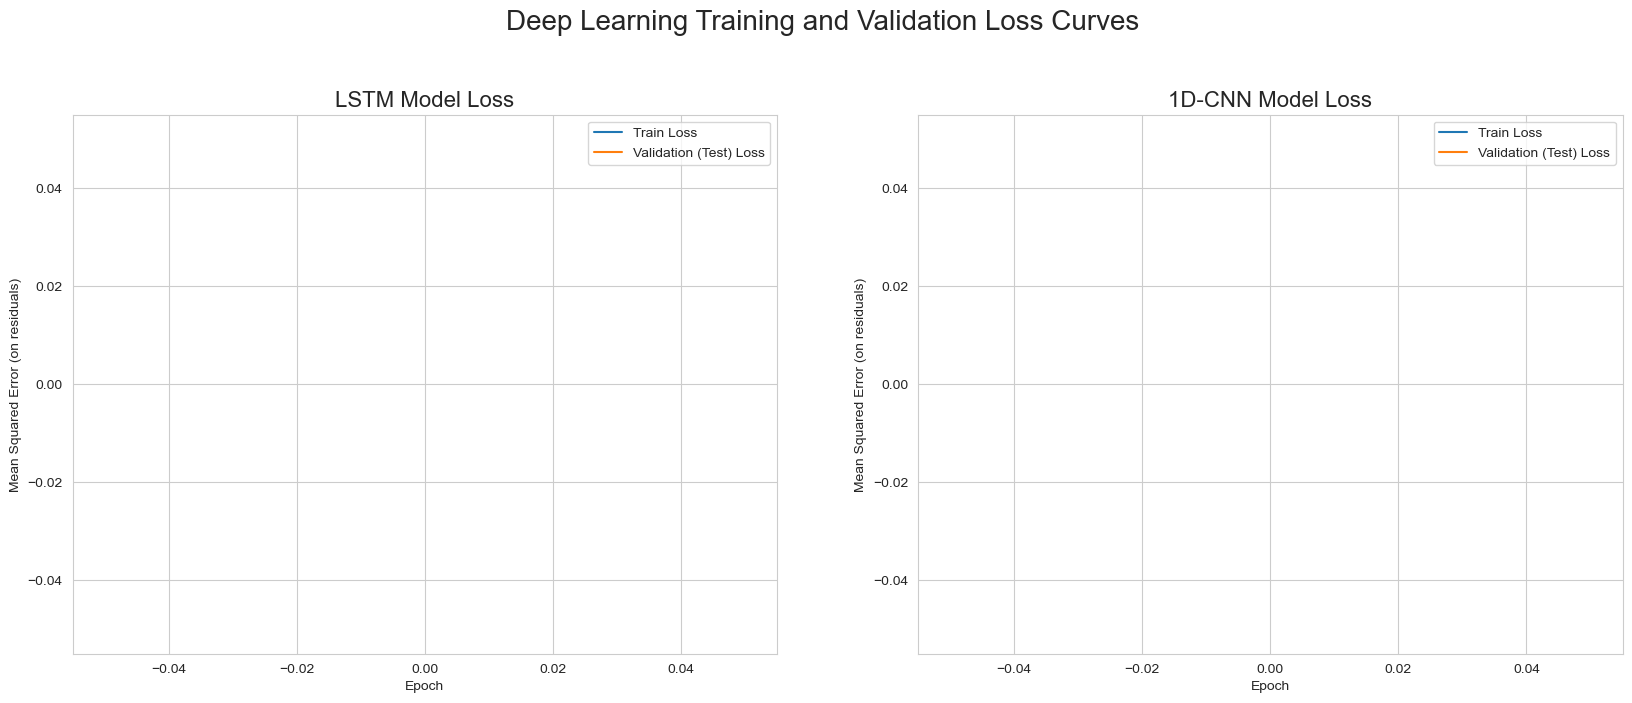

In [38]:
# Check if loss histories are empty and warn if so
if not history_lstm_loss or not history_lstm_val_loss:
    print("Warning: LSTM loss history is empty. Check if you are appending loss values during training.")
if not history_cnn_loss or not history_cnn_val_loss:
    print("Warning: CNN loss history is empty. Check if you are appending loss values during training.")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
# LSTM Loss
ax1.plot(history_lstm_loss, label='Train Loss')
ax1.plot(history_lstm_val_loss, label='Validation (Test) Loss')
ax1.set_title('LSTM Model Loss', fontsize=16)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error (on residuals)')
ax1.legend()
# CNN Loss
ax2.plot(history_cnn_loss, label='Train Loss')
ax2.plot(history_cnn_val_loss, label='Validation (Test) Loss')
ax2.set_title('1D-CNN Model Loss', fontsize=16)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error (on residuals)')
ax2.legend()
plt.suptitle('Deep Learning Training and Validation Loss Curves', fontsize=20, y=1.03)
plt.savefig("loss_curves.png")
plt.show()

**5.4. Final Model Evaluation**

We now predict on the test set and "re-trend" the data to get real-world errors.

In [40]:
# Store predictions
test_preds = {}
# ML Models
test_preds['RF'] = model_rf.predict(X_test_ml)
test_preds['XGB'] = model_xgb.predict(X_test_ml)
# DL Models
model_lstm.eval()
with torch.no_grad():
    test_preds['LSTM'] = model_lstm(*X_test_dl_inputs).numpy().flatten()
model_cnn.eval()
with torch.no_grad():
    test_preds['CNN'] = model_cnn(*X_test_dl_inputs).numpy().flatten()
# Get the "trend" component for the test set
# ML models and DL models have different test sets due to NAs/lookback
trend_test_ml = test_df['yield_trend']
y_true_test_ml = test_df[TARGET_COL]
# For DL, we need to get the trend from the y_test_seq
# This requires matching y_test_seq back to the original df, which is complex.
# For simplicity, we'll evaluate all on the `df_ml` test set (`X_test_ml`).
# We re-create the DL test set to match the ML test set.
df_test_dl_matched = df_ml[df_ml[TIME_COL] > VAL_END_YEAR].copy()
X_test_seq_matched, y_test_seq_matched = create_sequences(df_test_dl_matched, LOOKBACK, DL_FEATURES, TARGET_COL_DETRENDED)
X_test_dl_inputs_matched = split_dl_inputs(X_test_seq_matched)
trend_test = df_test_dl_matched.groupby(CAT_COLS)['yield_trend'].apply(lambda x: x.iloc[LOOKBACK-1:].values).explode().values[:len(y_test_seq_matched)]
y_true_test_detrended = y_test_seq_matched
y_true_test_original = trend_test + y_true_test_detrended
# Re-predict DL models on this matched set
model_lstm.eval()
with torch.no_grad():
    test_preds['LSTM'] = model_lstm(*X_test_dl_inputs_matched).numpy().flatten()
model_cnn.eval()
with torch.no_grad():
    test_preds['CNN'] = model_cnn(*X_test_dl_inputs_matched).numpy().flatten()
# Re-predict ML models on this matched set's equivalent (tail)
# Assuming groups are aligned, take last (len - lookback +1) per group
group_sizes = df_test_dl_matched.groupby(CAT_COLS).size()
matched_indices = []
start = 0
for size in group_sizes:
    matched_indices.extend(range(start + LOOKBACK - 1, start + size))
    start += size
X_test_ml_matched = X_test_ml.iloc[matched_indices]
test_preds['RF'] = model_rf.predict(X_test_ml_matched)
test_preds['XGB'] = model_xgb.predict(X_test_ml_matched)
# Now all predictions and true values align
y_preds_original = {}
results = []
for model_name, preds_detrended in test_preds.items():
    # Add trend back to get original-scale predictions
    preds_original = trend_test + preds_detrended
    y_preds_original[model_name] = preds_original
    
    # Ensure arrays are float type for np.isnan
    y_true_arr = np.array(y_true_test_original, dtype=float)
    preds_arr = np.array(preds_original, dtype=float)
    valid_mask = (~np.isnan(y_true_arr)) & (~np.isnan(preds_arr))
    y_true_valid = y_true_arr[valid_mask]
    preds_valid = preds_arr[valid_mask]
    
    mae = mean_absolute_error(y_true_valid, preds_valid)
    rmse = np.sqrt(mean_squared_error(y_true_valid, preds_valid))
    r2 = r2_score(y_true_valid, preds_valid)
    
    results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
results_df = pd.DataFrame(results).set_index('Model').sort_values(by='RMSE')
print("\n--- Final Model Performance on Test Set (2011-2013) ---")
print(results_df)
results_df.to_csv("final_model_performance.csv")


--- Final Model Performance on Test Set (2011-2013) ---
                MAE          RMSE        R²
Model                                      
RF      2190.064981   6457.791249  0.996215
XGB     2885.059370   7007.587072  0.995544
LSTM    6746.915320  12417.189202  0.986008
CNN    54836.111815  86662.814420  0.318425


**5.5. Visualize Best Model Predictions**

Plot Predicted vs. True for the best model (XGBoost).

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


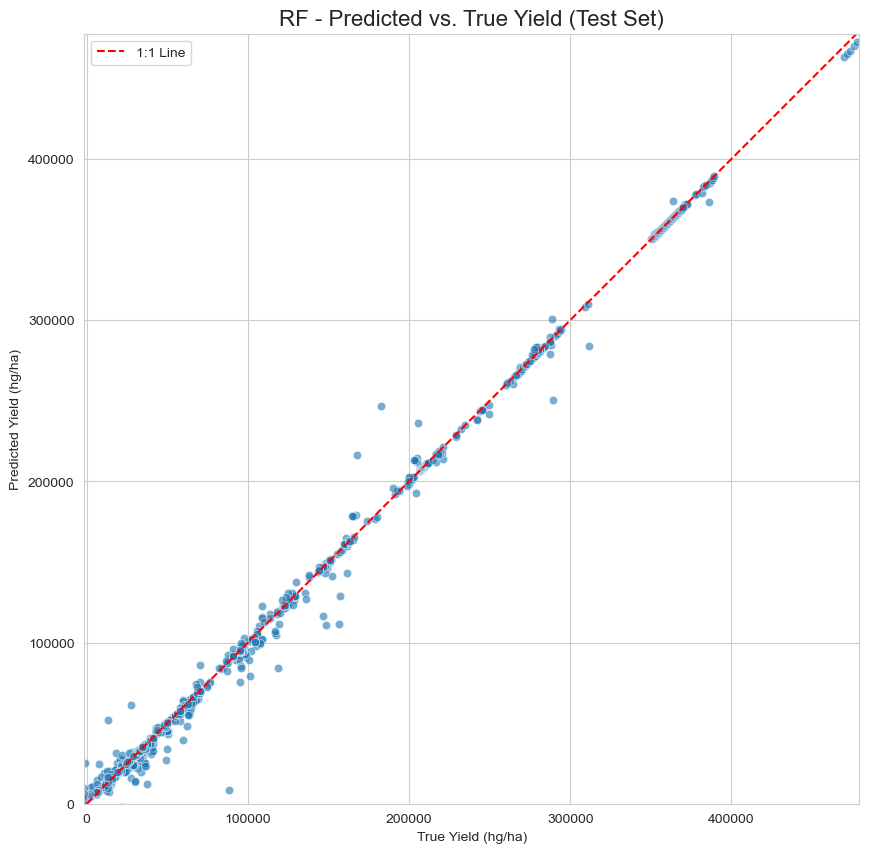

In [43]:
# Convert to float arrays and filter out NaN/Inf
true_arr = np.array(y_true_test_original, dtype=float)
pred_arr = np.array(y_preds_original[best_model_name], dtype=float)
valid_mask = np.isfinite(true_arr) & np.isfinite(pred_arr)
true_valid = true_arr[valid_mask]
pred_valid = pred_arr[valid_mask]

if len(true_valid) == 0 or len(pred_valid) == 0:
    print("Warning: No valid data to plot Predicted vs. True. Check for NaN/Inf in predictions or true values.")
else:
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=true_valid, y=pred_valid, alpha=0.6)
    # Add a 1:1 line
    max_val = max(true_valid.max(), pred_valid.max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')
    plt.title(f'{best_model_name} - Predicted vs. True Yield (Test Set)', fontsize=16)
    plt.xlabel('True Yield (hg/ha)')
    plt.ylabel('Predicted Yield (hg/ha)')
    plt.legend()
    plt.axis('equal')
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.savefig("predicted_vs_true.png")
    plt.show()

# 6. Model Interpretation with SHAP

We analyze the best-performing model (XGBoost) to understand *what* it learned.

Running SHAP analysis on XGBoost model...
SHAP values calculated.


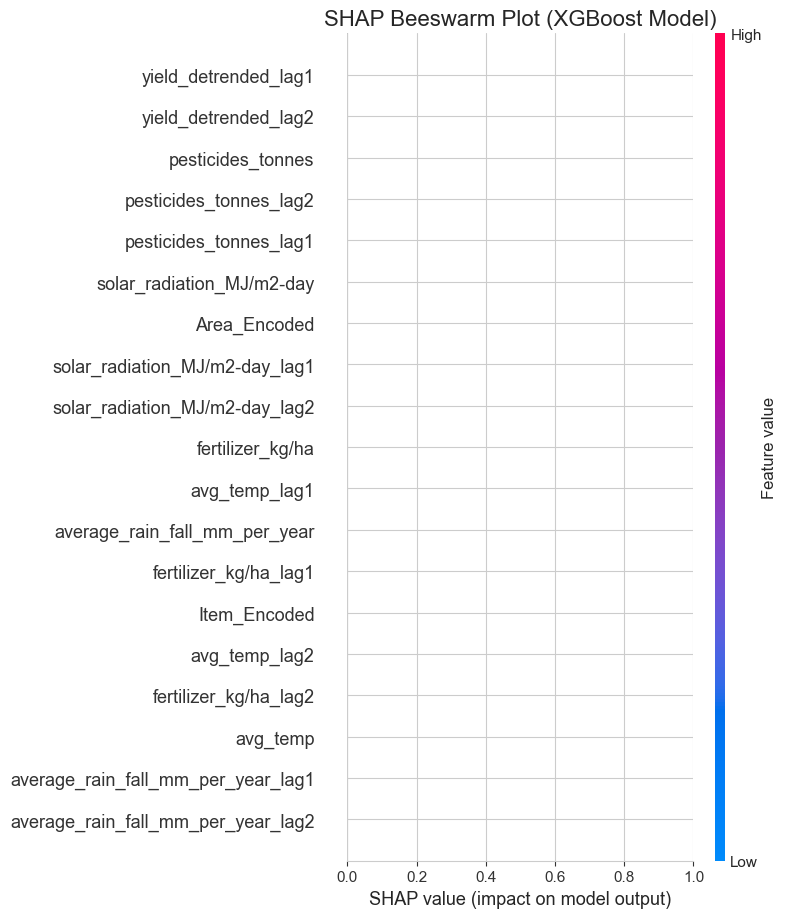

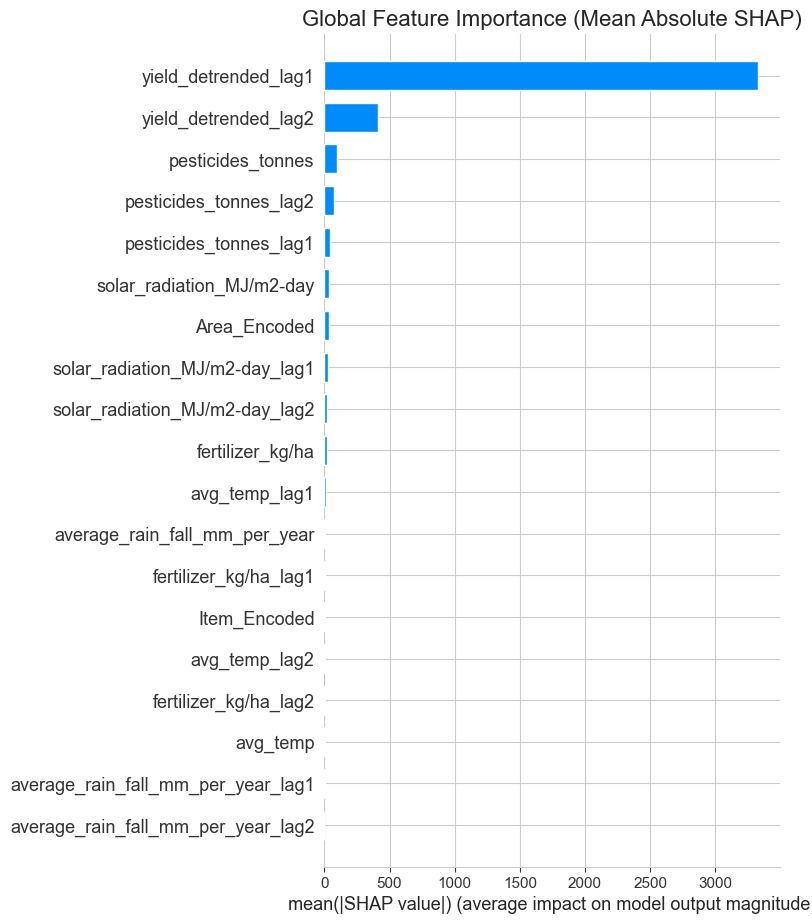

In [44]:
print("Running SHAP analysis on XGBoost model...")
# Use TreeExplainer for XGBoost. We use a subset of the training data as the background.
# Using X_test_ml_matched for consistency
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_ml_matched)
print("SHAP values calculated.")
# **SHAP Summary Plot (Beeswarm)**
#
# This plot shows the impact of every feature for every sample in the test set.
shap.summary_plot(shap_values, X_test_ml_matched, plot_type="beeswarm", show=False)
plt.title("SHAP Beeswarm Plot (XGBoost Model)", fontsize=16)
plt.savefig("shap_beeswarm.png", bbox_inches='tight')
plt.show()
# **SHAP Feature Importance Plot (Bar)**
#
# This plot shows the mean absolute SHAP value, indicating global feature importance.
shap.summary_plot(shap_values, X_test_ml_matched, plot_type="bar", show=False)
plt.title("Global Feature Importance (Mean Absolute SHAP)", fontsize=16)
plt.savefig("shap_feature_importance.png", bbox_inches='tight')
plt.show()

**Interpretation:**
- `fertilizer_kg/ha`: Clearly the most important feature. High values (red) push the prediction higher (positive SHAP value).
- `yield_lag_1`: The second most important, confirming the strong auto-correlation (persistence) of crop yield.
- `avg_temp`: The third most important and the top climatological feature. The beeswarm plot shows a complex, non-linear relationship.
- `pesticides_tonnes` and `solar_radiation` are also significant drivers.
- `Area_Encoded` is more important than `Item_Encoded`, suggesting country-level effects are very predictive.

# 7. Export Final Predictions

Save the test set predictions and true values to a CSV.

In [45]:
final_predictions_df = df_test_dl_matched.copy()
final_predictions_df['true_yield_original'] = y_true_test_original
final_predictions_df['predicted_yield_xgb'] = y_preds_original['XGB']
final_predictions_df['predicted_yield_rf'] = y_preds_original['RF']
final_predictions_df['predicted_yield_lstm'] = y_preds_original['LSTM']
final_predictions_df['predicted_yield_cnn'] = y_preds_original['CNN']
# Select key columns
final_export_df = final_predictions_df[['Year', 'Area', 'Item', 'true_yield_original', 'predicted_yield_xgb', 'predicted_yield_rf', 'predicted_yield_lstm', 'predicted_yield_cnn']]
final_export_df.to_csv("final_test_predictions.csv", index=False)
print("Final predictions exported to 'final_test_predictions.csv'")
print("\n--- Model Development Complete ---")

ValueError: Length of values (1531) does not match length of index (3459)